<a href="https://colab.research.google.com/github/Jeiderbeltran/IA_Tizon_Tardio_Hojas_Tomate_/blob/main/IA_Tizon_Tardio_Hojas_Tomate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================
# Instalacion de  dependencias
# ==============================================
!pip install -q tensorflow tensorflow-datasets git-lfs
!git lfs install

# ==============================================
# Clonar el repositorio con las imágenes
# ==============================================
!git clone https://github.com/Jeiderbeltran/IA_Tizon_Tardio_Hojas_Tomate_.git

import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ==============================================
# Directorios
# ==============================================
base_dir = "/content/IA_Tizon_Tardio_Hojas_Tomate_/dataset_organizado"

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

BATCH_SIZE = 25
SEED = 123

# ==============================================
# Cargar datasets
# ==============================================
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='int',
    batch_size=None, shuffle=True, seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, labels='inferred', label_mode='int',
    batch_size=None, shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, labels='inferred', label_mode='int',
    batch_size=None, shuffle=False
)

# ==============================================
# Funciones de preprocesamiento
# ==============================================
def segment_leaf(image):
    img = np.array(image)

    # Manejo de formatos
    if img.ndim == 2:  # Gris
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.ndim == 3:
        if img.shape[-1] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[-1] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        elif img.shape[-1] != 3:
            img = np.repeat(img[..., :1], 3, axis=-1)
    else:
        img = np.stack([img]*3, axis=-1)

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Rango de color para hoja enferma
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([95, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    lower_brown = np.array([10, 30, 30])
    upper_brown = np.array([25, 255, 255])
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)

    mask = cv2.bitwise_or(mask_green, mask_brown)
    #Limpieza
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #Segmentar hojas grandes
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        mask_clean = np.zeros_like(mask)
        cv2.drawContours(mask_clean, [c], -1, 255, -1)
        segmented = cv2.bitwise_and(img, img, mask=mask_clean)
    else:
        segmented = img

    return segmented

  # Eliminacion de ruido
def denoise_image(image):
    return cv2.medianBlur(image, 3)

  # Escala de grises
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
 # Normalizacion
def normalize_image(image):
    return image.astype("float32") / 255.0


# ==============================================
# Aumento de datos
# ==============================================
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def custom_preprocessing(image, label):
    image = image.numpy()

    # Preprocesamiento
    image = segment_leaf(image)
    image = denoise_image(image)
    image = to_grayscale(image)
    image = cv2.resize(image, (256, 256))
    image = normalize_image(image)


    image = np.expand_dims(image, axis=-1)
    return image.astype("float32"), label


def tf_wrapper(image, label):
    img, lbl = tf.py_function(
        func=custom_preprocessing,
        inp=[image, label],
        Tout=[tf.float32, tf.int32]
    )

    img = tf.reshape(img, (256, 256, 1))
    lbl.set_shape(())
    return img, lbl


# ==============================================
# Aplicacion a datasets
# ==============================================
train_ds_pre = train_ds.map(tf_wrapper).batch(BATCH_SIZE)
val_ds_pre   = val_ds.map(tf_wrapper).batch(BATCH_SIZE)
test_ds_pre  = test_ds.map(tf_wrapper).batch(BATCH_SIZE)

#Aumento de datos
train_ds_pre = train_ds_pre.map(lambda x, y: (data_augmentation(x, training=True), y))

train_ds_pre = train_ds_pre.prefetch(tf.data.AUTOTUNE)
val_ds_pre   = val_ds_pre.prefetch(tf.data.AUTOTUNE)
test_ds_pre  = test_ds_pre.prefetch(tf.data.AUTOTUNE)

print("datos creados correctamente")


Git LFS initialized.
Cloning into 'IA_Tizon_Tardio_Hojas_Tomate_'...
remote: Enumerating objects: 3530, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 3530 (delta 7), reused 12 (delta 2), pack-reused 3508 (from 2)
Receiving objects: 100% (3530/3530), 117.28 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (7021/7021), done.
Filtering content: 100% (3/3), 193.19 MiB | 38.14 MiB/s, done.
Found 2464 files belonging to 2 classes.
Found 700 files belonging to 2 classes.
Found 351 files belonging to 2 classes.
datos creados correctamente


In [3]:
# ==============================================
# Modelo de red neuronal Convolucional para deteccion del tizon tardio
# ==============================================

import tensorflow as tf
from tensorflow.keras import layers, models



def build_cnn(input_shape=(256, 256, 1), num_classes=2):
    model = models.Sequential([


        # Primera capa
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding="same"),
        layers.MaxPooling2D((2,2)),

        # Segunda capa
        layers.Conv2D(64, (3,3), activation='relu', padding="same"),
        layers.MaxPooling2D((2,2)),

        # Tercera capa
        layers.Conv2D(128, (3,3), activation='relu', padding="same"),
        layers.MaxPooling2D((2,2)),


        # Evitar sobreajuste
        layers.Dropout(0.3),

        # Aplanado y capa densa
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        # Capa de salida
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compilación del modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Crear el modelo
cnn_model = build_cnn(input_shape=(256, 256, 1), num_classes=2)



In [ ]:
# ==============================================
# Proceso de entrenamineto del modelo
# ==============================================

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# Entrenamiento
history = cnn_model.fit(
    train_ds_pre,
    validation_data=val_ds_pre,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
 1/99 ━━━━━━━━━━━━━━━━━━━━ 12:46 8s/step - accuracy: 0.6400 - loss: 0.6848

KeyboardInterrupt: 

In [ ]:
# ==============================================
# Proceso de descarga local del moledo entrenado
# ==============================================

import os
import datetime
from tensorflow.keras.models import load_model
from google.colab import files

nombre_modelo = f"modelo_tizon_v{datetime.datetime.now().strftime('%Y%m%d_%H%M')}.keras"


best_model_path = "best_model.h5"
if not os.path.exists(best_model_path):
    raise FileNotFoundError(" No se encontró el archivo 'best_model.h5'.")


modelo = load_model(best_model_path)
modelo.save(nombre_modelo)
print(f" Modelo guardado  como: {nombre_modelo}")

#Descargar archivo
files.download(nombre_modelo)
print(" Descarga iniciada. Espera unos segundos para guardar el archivo en tu PC.")



FileNotFoundError:  No se encontró el archivo 'best_model.h5'.

In [ ]:
# ==============================================
# Porceso de importacion del modelo desde el PC
# ==============================================

from google.colab import files
from tensorflow.keras.models import load_model

#  modelo desde PC
uploaded = files.upload()

nombre_modelo = list(uploaded.keys())[0]
print(f"Archivo detectado: {nombre_modelo}")

modelo = load_model(nombre_modelo)
print("Modelo cargado correctamente")


KeyboardInterrupt: 

In [5]:
# ==============================================
# Moldeo modelo_tizon_v20251020_2218. entrenado
# ==============================================

!apt-get install git-lfs -y
!git lfs install

!git clone https://github.com/Jeiderbeltran/IA_Tizon_Tardio_Hojas_Tomate_.git

from tensorflow.keras.models import load_model

ruta = "/content/IA_Tizon_Tardio_Hojas_Tomate_/modelos_entrenados/modelo_tizon_v20251020_2218.keras"
modelo = load_model(ruta)

print("Modelo cargado correctamente desde GitHub (LFS)")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Git LFS initialized.
fatal: destination path 'IA_Tizon_Tardio_Hojas_Tomate_' already exists and is not an empty directory.
Modelo cargado correctamente desde GitHub (LFS)


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
# ==============================================
# Evaluación del modelo
# ==============================================
test_loss, test_acc = modelo.evaluate(test_ds_pre)
print(f"Precisión del modelo cargado: {test_acc*100:.2f}%")
print(f"Pérdida final: {test_loss:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9756 - loss: 0.0599
Precisión del modelo cargado: 98.01%
Pérdida final: 0.0465


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 896ms/step


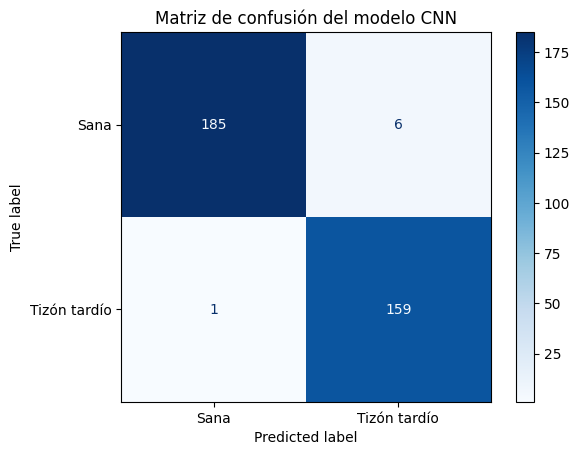

Verdaderos Negativos (TN): 185
Falsos Positivos (FP): 6
Falsos Negativos (FN): 1
Verdaderos Positivos (TP): 159


In [ ]:
# ==============================================
# Grafica de matriz de confusión del modelo evaluado
# ==============================================
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener predicciones
y_true = np.concatenate([y for x, y in test_ds_pre], axis=0)
y_pred = np.argmax(modelo.predict(test_ds_pre), axis=1)

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sana', 'Tizón tardío'])
disp.plot(cmap='Blues')
plt.title('Matriz de confusión del modelo CNN')
plt.show()

# Extraer los valores individuales
TN, FP, FN, TP = cm.ravel()

print(f"Verdaderos Negativos (TN): {TN}")
print(f"Falsos Positivos (FP): {FP}")
print(f"Falsos Negativos (FN): {FN}")
print(f"Verdaderos Positivos (TP): {TP}")

